# Problem Statement

**Setup**

- Multiple machines compute gradients in parallel, and a centralized server updates the model weights.

**Problem**

- The distributed empirical risk minimization (ERM) problem in the form of logistic regression.

**Input data**

- Feature vector $z_i \in R^d$ and real parameters $x \in R^d$ of the model. 

**Output data**

- Prediction for a target variable $y \in \{-1, 1\}$.

**Main Idea**

- In distributed learning, **build a uniform batch on a server as an i.i.d. sample of the general distribution**.

- In regularization, use the distance between the gradients on the local batches (on the devices) and on the uniform batch (on the server). This will decrease the number of communications before the convergence achieved.

- The method reduces the convergence rate from $O\left(\kappa_F \log (1 / \epsilon)\right)$ to $O\left(\sqrt{\kappa_{F/\phi}} \log (1 / \epsilon)\right)$, where $\kappa_{F/\phi}$ is the relative condition number between the global and local loss functions.

# Theory

It was shown that with first-order methods, the communication complexity of $O\left(\kappa_{F} \log (1 / \epsilon)\right)$ obtained with accelerated proximal gradient methods cannot be improved [1].

However, the researchers noticed that for distributed ERM, there exists further improvement. If the datasets Dj at different workers are i.i.d. samples from the same source distribution, then the local empirical losses $f_j(x)$ are statistically very similar to each other and to their average $F(x)$, especially when $n$ is large.

The paper introduces a **Statistically Preconditioned Accelerated Gradient method (SPAG)** that reduces communication complexity based on this insight. The preconditioning implies solving a local optimization problem over a subsampled dataset at the server.

- **Assumption 1:** The dataset of $N$ samples is distributed evenly between the machines: $N = mn$, where $m$ is the number of machines and $n$ is the number of samples stored at each machine.

**Training process**

- The model parameters are learnt during minimization of the average loss on dataset $F(x)$:

    $$F(x)=\frac{1}{N} \sum_{i=1}^N \ell\left(x, z_i\right) = \frac{1}{N} \sum_{i=1}^N\left\{\log \left[1+\exp \left(-y_i\left\langle x, z_i\right\rangle\right)\right]+0.5 \cdot \lambda \cdot\|x\|_2^2\right\}$$

    where $x$ - model weights, $y_i$ - true label, $z_i$ - feature vector.

- On each iteration, the gradient is computed in a distributed way on $m$ machines.

- Server contains a uniform approximation of $F(x)$ that is built using $(n<<N)$ data samples:

    $$f(x)= \frac{1}{n} \sum_{i=1}^n \ell\left(x, z_i\right)$$

**Standard Approach**

- To perform proximal gradient descent at the server:

    $$x_{t+1}=\underset{x \in \mathbb{R}^d}{\operatorname{argmin}}\left\{\nabla F\left(x_t\right)^{\top} x+\psi(x)+\frac{1}{2 \eta_t}\left\|x-x_t\right\|^2\right\}$$

    where $\|\cdot\|$ denotes the Euclidean norm and $\eta_t>0$ is the step size.
    
    Setting $\eta_t=1 / L_F$ leads to linear convergence.
    

- **Assumption 2:** The overall impirical risk of the model is $L_F$-smooth and $\sigma_F$-strongly convex over $\psi$ (a convex regularization function).
    
    $$\sigma_F I_d \preceq \nabla^2 F(x) \preceq L_F I_d, \quad \forall x \in \operatorname{dom} \psi$$

    Hence, the convergence rate depends on the condition number $\kappa_F = L_F / \sigma_F$:
    
    $$O\left(\kappa_F \log (1 / \epsilon)\right)$$

**Proposed Approach**

- In the paper, a worker 1 computes $x_{t+1}$ by solving an optimization problem involving the local loss function $f_1$.

- Minimization of $F(x)$ is performed using **the proximal gradient method with the Bregman divergence** of $\phi$:

    $$x_{t+1}=\underset{x \in \mathbb{R}^d}{\operatorname{argmin}}{ }\left\{\nabla F\left(x_t\right)^T x+\frac{1}{\eta_t} D_\phi\left(x, x_t\right)\right\} { } (1)$$

    Where $D_\phi$ is the Bregman divergence of a convex and differentiable fucntion $\phi$:

    $$D_\phi(x, y)=\phi(x)-\phi(y)-\nabla \phi(y)^T(x-y)$$

    And $\phi(x)$ is regularized uniform approximation of the total loss $F(x)$:

    $$\phi(x)=f(x)+0.5 \mu\|x\|_2^2$$

**What are the benefits?**


- **Assumption 3:** the function $\phi$ is convex, twice differentiable, $L_{\phi}$-smooth and $\sigma_{\phi}$-strongly convex.

- **Assumption 4:** the function $F$ is $L_{F / \phi}$-smooth and $\sigma_{F / \phi}$-strongly convex with respect to $\phi$:
$$
\forall x \in \mathbb{R}^d : \sigma_{F / \phi} \nabla^2 \phi(x) \preceq \nabla^2 F(x) \preceq L_{F / \phi} \nabla^2 \phi(x) \ { } 
$$

- We can define **the relative condition number of $F$ with respect to $\phi$** as $\kappa_{F / \phi}=L_{F / \phi} / \sigma_{F / \phi}$

    According to  to [2] and [3], setting $\eta_t=1 / L_{F/\phi}$ leads to linear convergence as well.

- **The advantage:** the effectiveness of preconditioning depends on how much smaller $\kappa_{F / \phi}$ compared to $\kappa_F$.

    The better $f_1$ (or $\phi$) approximates $F$, the smaller $\kappa_{F / \phi} \geq 1$ is.
    
    Sanity check: in the extreme case of $f_1 \equiv F$ (with only one machine $m=1$ ), we can choose $\mu=0$ and thus $\phi \equiv F$, which leads to $\kappa_{F / \phi}=1$, and we obtain the solution within one step of our algorithm.

    In general, we choose $\mu$ to be an upper bound on the spectral norm of the matrix difference $\nabla^2 f_1(x)-\nabla^2 F(x)$.
    
- **Assumption 5:** with high probability,
    $$
    \left\|\nabla^2 f_1(x)-\nabla^2 F(x)\right\|_2 \leq \mu, \quad \forall x \in \operatorname{dom} \psi
    $$

    This inequality implies Lemma 3 from [4]:

    $$\frac{\sigma_F}{\sigma_F+2 \mu} \nabla^2 \phi(x) \preceq \nabla^2 F(x) \preceq \nabla^2 \phi(x)$$

    And this Lemma gives us the initialization parameters for the algorithm:

- **Initialization:** SPAG is initialized with the following parameters:

    $$L_{F / \phi}=1, \ \ \ \ \ \ \sigma_{F / \phi}=\frac{\sigma_F}{\sigma_F+2 \mu}, \ \ \ \ \ \ x_0=\operatorname{argmin}_x f(x)$$

**Estimation of $\kappa_{F / \phi}$**

- If losses $l(x, z_i)$ are *quadratic in $x$*:

    $$\kappa_{F / \phi}=1+\frac{2 \mu}{\sigma_F}=1+\widetilde{O}\left(\frac{\kappa_{\ell}}{\sqrt{n}}\right)$$

    Therefore, for large $n$, preconditioning is effective as $\underset{n \rightarrow \infty}{\operatorname{lim}} \kappa_{F / \phi} = 1$ 

- In case the loss function is *non-quadratic in $x$*:

    $$\kappa_{F / \phi}=1+\frac{2 \mu}{\sigma_F}=1+\widetilde{O}\left(\frac{\kappa_{\ell}{\sqrt{d}}}{\sqrt{n}}\right)$$

    In this case, the effectiveness of preconditioning depends not solely on $n$, but also on the dimensionality $d$. The benefit may degrade or even disappear in high dimension.

# SPAG Algorithm

The SPAG algorithm is presented below:

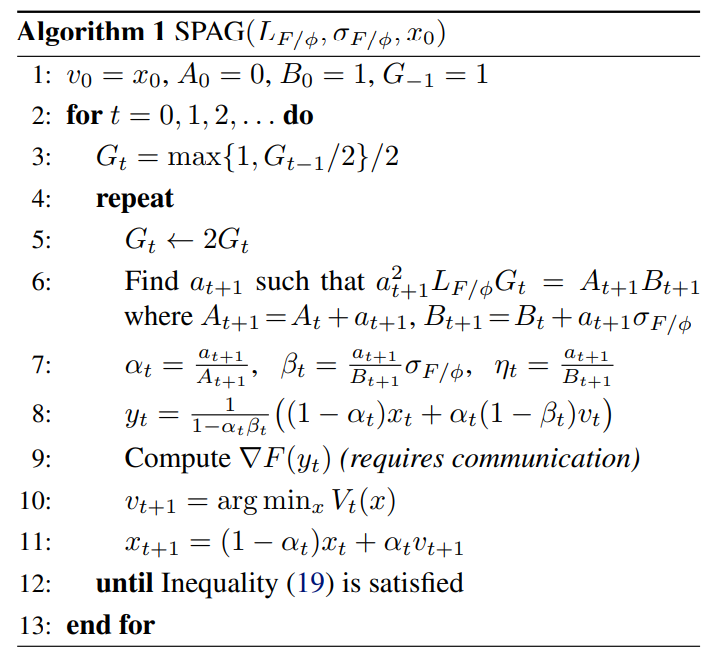

- During each iteration, Line 6 finds $a_{t+1}>0$ by solving a quadratic equation.

- Then Line 7 calculates three scalars $\alpha_t, \beta_t$ and $\eta_t$, which are used in the later updates for the three vectors $y_t, v_{t+1}$ and $x_{t+1}$.

- The function $V_t(\cdot)$ being minimized in Line 10 is defined as
    $$
    V_t(x)= \eta_t\left(\nabla F\left(y_t\right)^{\top} x+\psi(x)\right) +\left(1-\beta_t\right) D_\phi\left(x, v_t\right)+\beta_t D_\phi\left(x, y_t\right)
    $$

- The inequality from Line 12 is
    $$
    D_\phi\left(x_{t+1}, y_t\right)
    \leq \alpha_t^2 G_t\left(\left(1-\beta_t\right) D_\phi\left(v_{t+1}, v_t\right)+\beta_t D_\phi\left(v_{t+1}, y_t\right)\right)
    $$
    where $G_t$ is a scaling parameter depending on the properties of $D_\phi$. It is a more flexible version of the triangle scaling gain introduced by [5].

# Experiments

We have reproduced some expirements from the original paper.

We used the RVC1 dataset (~20k samples, ~47k features) for optimizing the loss function in logistic regression task.

There are two implemented methods in the `notebooks/experiments.ipynb` notebook:

- **SPAG** - the one described in the paper.
- **Accelerated Gradient Descent** - the method to compare against SPAG.

As expected, SPAG shown faster convergence than AGD from the same initial point.

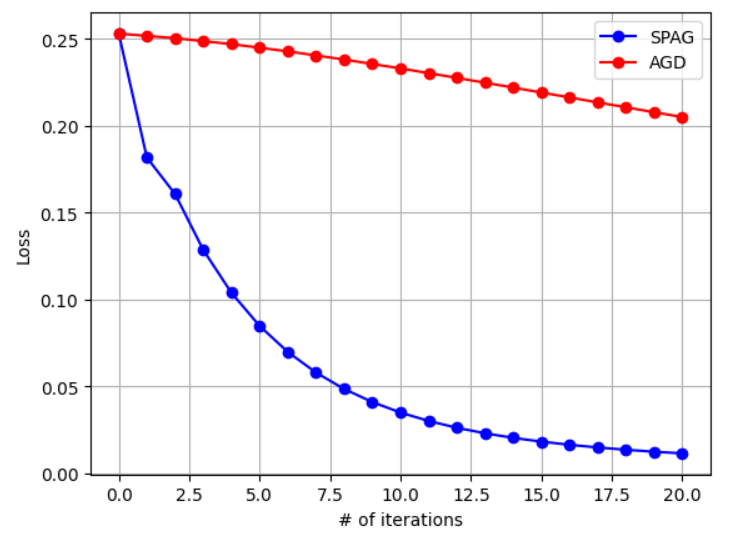

# References

1. Kevin Scaman, Francis Bach, Sebastien Bubeck, Yin Tat Lee, and Laurent Massoulie. Optimal algorithms for smooth and strongly convex distributed optimization in networks. In Proceedings of the International Conference on Machine Learning (ICML), pages 3027–3036, 2017.

2. Ohad Shamir, Nati Srebro, and Tong Zhang. Communication-efficient distributed optimization using an approximate Newton-type method. In International Conference on Machine Learning, pages 1000–1008, 2014.

3. Haihao Lu, Robert M Freund, and Yurii Nesterov. Relatively smooth convex optimization by first-order methods, and applications. SIAM Journal on Optimization, 28(1):333–354, 2018.

4. Yuchen Zhang and Lin Xiao. Communication-efficient distributed optimization of self-concordant empirical loss. In Large-Scale and Distributed Optimization, number 2227 in Lecture Notes in Mathematics, chapter 11, pages 289–341. Springer, 2018.

5. Filip Hanzely, Peter Richtarik, and Lin Xiao. Accelerated Bregman proximal gradient methods for relatively smooth convex optimization. arXiv:1808.03045, 2018.